# Data analysis

In this script, we try to make a distinction between EBH and LBH. We will look at the frequency of function types and compare them between the books.

In [2]:
import pandas as pd
import numpy as np

import glob
import re 
import collections
import operator
from discreteMarkovChain import markovChain
import scipy.stats
import sklearn.metrics

import matplotlib.pyplot as plt

## Loading the data


Each Biblical book is transformed from literal translation of the Bibical text to phrase functions. Each line of phrase functions is one clause. 

For a definition of each phrase function
https://etcbc.github.io/bhsa/features/hebrew/c/function

For the data exploration:
http://bibleol.3bmoodle.dk/text/select_text

All ".txt" files of the books in terms of phrase functions are stored in a folder named "phrase_functions". All direction names of these files are obtained by a function "glob.glob" and stored. All book names are stored in a list "book_names"

In [3]:
phrase_functions_books_dir = glob.glob("Data/phrase_functions/*.txt")

bookNames = []
for book_dir in phrase_functions_books_dir:
    bookNames.append(re.search('phrase_functions_(.*?).txt', book_dir).group(1))

Let us define the following set consisting of the names of the books we are looking at $B=[{bookNames[1],bookNames[2],...,bookNames[k]}]$ where $k$ =number of books.

In [4]:
print(bookNames)

['Chronica_I', 'Chronica_II', 'Deuteronomium', 'EBH', 'Esra', 'Esther', 'Exodus', 'Genesis', 'Josua', 'Judices', 'LBH', 'Leviticus', 'Nehemia', 'Reges_I', 'Reges_II', 'Samuel_I', 'Samuel_II']


We now want to store all books in a list. The phrase functions of a clause is stored in a list where this list is the length of the total number of phrase functions. Each clause list is then according to order of reading the clauses stored in a book list of clause lists. The bookContents consists of all book list for each book. So

booksContents = $C_{b,c(b),f(b,c)}$ =phrase function $f$ in clause $c$ of book $b$ where
$$b = \{1,2,...,k\}$$
$$c(b) = \{1,2,...,l(b)\}$$ 
$$f(b,c) = \{1,2,...,m(b,c)\}$$ 
$l(b)$ = number of clauses of book $b$, 
$m(b,c)$ = number of phrase functions of book $b$ of clause $c$

In [5]:
booksContents = []
for book_dir in phrase_functions_books_dir:
    content = []
    with open(book_dir) as f:
        for line in f:
            content.append(line.strip().split(' '))
    booksContents.append(content) 


Example $C_{1,1}$,$C_{1,2}$, $C_{1,3}$

In [6]:
print(bookNames[0])
print(booksContents[0][:3])

Chronica_I
[['Conj', 'Pred', 'Subj', 'Objc'], ['Subj', 'PreC'], ['Subj', 'PreC']]


Now that the data is stored, we are interested in doing some analysis on the phrase functions. First we must know with which phrase functions we work. Let us define a variable which indicates the unique functions: $f= \{1,2,...,n\}$ where $n$ is the amount of unique functions.


In [7]:
uniqueFunctions = set()
for book in booksContents:
    for clause in book:
        for function in clause:
            uniqueFunctions.add(function)
uniqueFunctions = sorted(list(uniqueFunctions))
print(uniqueFunctions)

['Adju', 'Cmpl', 'Conj', 'Exst', 'Frnt', 'IntS', 'Intj', 'Loca', 'ModS', 'Modi', 'NCoS', 'NCop', 'Nega', 'Objc', 'PrAd', 'PreC', 'PreO', 'PreS', 'Pred', 'PtcO', 'Ques', 'Rela', 'Subj', 'Supp', 'Time']


Another measure we can look at is the number of functions in a clause. For determining this, we need the minimal number of functions in a clause and the maximum number of functions in a clause. 

In [8]:
minBook = len(book[0][0])
maxBook = len(book[0][0])
for book in booksContents:
    for clause in book:
        numberOfFunctions = len(clause)
        if minBook > numberOfFunctions:
            minBook = numberOfFunctions
        if maxBook < numberOfFunctions:
            maxBook = numberOfFunctions
#Minimal number of functions in a sentence
print(minBook)
#Maximum number of functions in a sentence
print(maxBook)

1
8


 # Counting Frequency phrase functions

We are interested in finding the frequency of the phrase functions in the books.

In [9]:
zeromatrix= np.zeros((len(uniqueFunctions), len(bookNames)))

for indexC,book in enumerate(booksContents):
    for clause in book:
        for function in clause:
            indexR = uniqueFunctions.index(function) 
            zeromatrix[indexR][indexC]+=1
        
df_freq = pd.DataFrame(zeromatrix, columns = bookNames )
df_freq.index = pd.Series(uniqueFunctions)

#Sample
df_freq

,Chronica_I,Chronica_II,Deuteronomium,EBH,Esra,Esther,Exodus,Genesis,Josua,Judices,LBH,Leviticus,Nehemia,Reges_I,Reges_II,Samuel_I,Samuel_II
Adju,241.0,375.0,58.0,355.0,79.0,60.0,168.0,166.0,114.0,92.0,61.0,18.0,84.0,168.0,151.0,75.0,101.0
Cmpl,414.0,857.0,220.0,1977.0,108.0,207.0,557.0,1219.0,660.0,799.0,209.0,154.0,287.0,740.0,803.0,889.0,736.0
Conj,829.0,1536.0,335.0,4052.0,185.0,280.0,1184.0,2548.0,973.0,1381.0,288.0,217.0,513.0,1374.0,1463.0,1733.0,1362.0
Exst,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frnt,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
IntS,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Intj,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loca,40.0,91.0,25.0,250.0,17.0,11.0,121.0,118.0,55.0,54.0,11.0,8.0,53.0,76.0,79.0,61.0,53.0
ModS,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Modi,24.0,39.0,9.0,146.0,7.0,8.0,52.0,83.0,36.0,37.0,9.0,8.0,19.0,45.0,35.0,49.0,50.0


In [84]:
zeromatrix= np.zeros((len(bookNames), len(bookNames)))

for indexi,i in enumerate(df_freq):
    for indexj,j in enumerate(df_freq):
        if indexi>indexj:
            #Chi square test
            dfTemp = df_freq[[i,j]]
            dfTemp = dfTemp[(dfTemp.T != 0).any()]
            matrix = dfTemp.values
            m= np.matrix(matrix).transpose()
            m = m.astype(int)
            chi2, p, dof, ex = scipy.stats.chi2_contingency(m)
           
            #Anderson-Darling test
            matrix = list(map(list, zip(*matrix)))
            matrix[0] = matrix[0]/sum(matrix[0])
            matrix[1] = matrix[1]/sum(matrix[1])
            #s,c,p = scipy.stats.anderson_ksamp(matrix)
            zeromatrix[indexi][indexj] = round(p,5)    
            

#KS test
df_freq_test= pd.DataFrame(zeromatrix, columns = bookNames)
df_freq_test.index = pd.Series(bookNames)
df_freq_test = df_freq_test.replace(0.0, np.nan)
df_freq_test

,Chronica_I,Chronica_II,Deuteronomium,EBH,Esra,Esther,Exodus,Genesis,Josua,Judices,LBH,Leviticus,Nehemia,Reges_I,Reges_II,Samuel_I,Samuel_II
Chronica_I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chronica_II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Deuteronomium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EBH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Esra,0.00095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Esther,NaN,0.0086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exodus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genesis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Josua,NaN,NaN,NaN,NaN,NaN,0.01943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Judices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


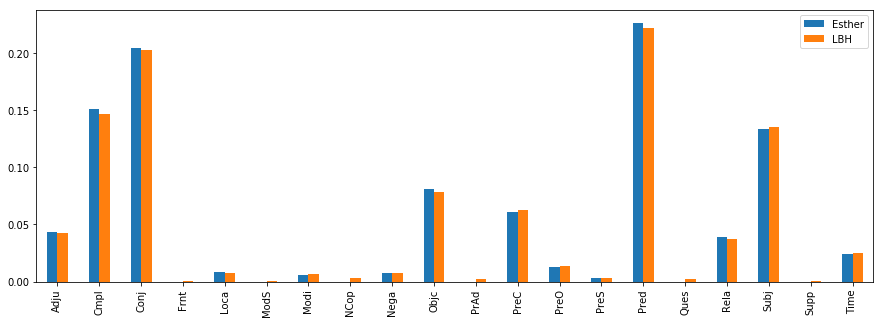

In [85]:
df = df_freq[["Esther","LBH"]]
df_new = df.div(df.sum(axis=0), axis=1)
df_new = df_new[(df_new.T != 0).any()]
plt.figure()
df_new.plot(figsize = (15,5), kind='bar')

plt.show()

In [30]:
zeromatrix= np.zeros((maxBook-minBook+1, len(bookNames)))

for indexC,book in enumerate(booksContents):
    for clause in book:
        zeromatrix[len(clause)-1][indexC]+=1

df_len = pd.DataFrame(zeromatrix, columns = bookNames)
df_len.index = pd.Series(list(range(minBook,maxBook+1)))
df_len

,Chronica_I,Chronica_II,Deuteronomium,EBH,Esra,Esther,Exodus,Genesis,Josua,Judices,LBH,Leviticus,Nehemia,Reges_I,Reges_II,Samuel_I,Samuel_II
1,77.0,107.0,51.0,296.0,44.0,23.0,98.0,149.0,76.0,67.0,23.0,37.0,64.0,110.0,95.0,95.0,76.0
2,327.0,456.0,101.0,1172.0,110.0,94.0,320.0,777.0,314.0,344.0,96.0,39.0,220.0,506.0,448.0,440.0,339.0
3,417.0,818.0,174.0,1753.0,118.0,166.0,543.0,1121.0,437.0,665.0,170.0,69.0,260.0,710.0,786.0,784.0,610.0
4,325.0,581.0,130.0,1564.0,74.0,104.0,482.0,922.0,385.0,480.0,107.0,123.0,182.0,502.0,499.0,625.0,505.0
5,83.0,152.0,37.0,395.0,24.0,42.0,137.0,213.0,114.0,126.0,45.0,21.0,46.0,113.0,106.0,147.0,117.0
6,18.0,45.0,11.0,62.0,4.0,4.0,15.0,32.0,26.0,21.0,5.0,5.0,12.0,26.0,14.0,16.0,17.0
7,3.0,9.0,1.0,12.0,0.0,2.0,5.0,6.0,8.0,2.0,2.0,0.0,3.0,3.0,1.0,1.0,4.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
zeromatrix= np.zeros((len(bookNames), len(bookNames)))

for indexi,i in enumerate(df_len):
    for indexj,j in enumerate(df_len):
        if indexi>indexj:
            #Chi square test
            dfTemp = df_len[[i,j]]
            dfTemp = dfTemp[(dfTemp.T != 0).any()]
            matrix = np.matrix(dfTemp.values)
            matrix = matrix.transpose()
            chi2, p, dof, ex = scipy.stats.chi2_contingency(matrix)
            zeromatrix[indexi][indexj] = round(p,4)      

#KS test
df_len_test= pd.DataFrame(zeromatrix, columns = bookNames)
df_len_test.index = pd.Series(bookNames)
df_len_test = df_len_test.replace(0.0, np.nan)
df_len_test


,Chronica_I,Chronica_II,Deuteronomium,EBH,Esra,Esther,Exodus,Genesis,Josua,Judices,LBH,Leviticus,Nehemia,Reges_I,Reges_II,Samuel_I,Samuel_II
Chronica_I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chronica_II,0.0056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Deuteronomium,0.0155,0.0008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EBH,0.0351,0.0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Esra,0.0037,NaN,0.0290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Esther,0.0902,0.2937,0.0596,0.0849,0.0007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exodus,0.0018,0.0020,0.0057,0.3798,NaN,0.2484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genesis,0.1161,0.0006,NaN,0.0640,NaN,0.0608,0.0026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Josua,0.1335,0.0418,0.0097,0.0716,NaN,0.1774,0.0735,0.0029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Judices,0.0001,0.0984,NaN,0.0006,NaN,0.1766,0.0052,0.0124,0.0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


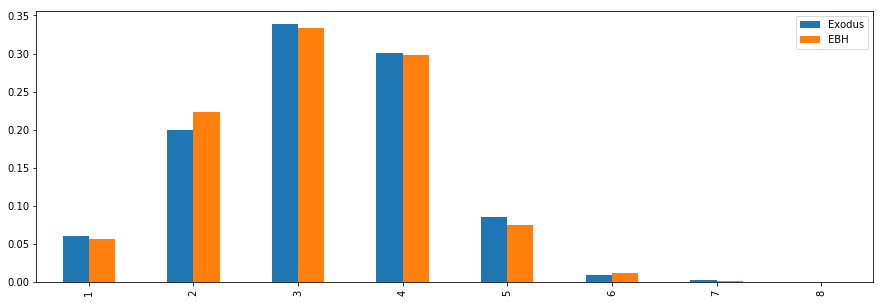

In [32]:
df = df_len[["Exodus","EBH"]]
df_new = df.div(df.sum(axis=0), axis=1)
plt.figure()
df_new.plot(figsize = (15,5), kind='bar')

plt.show()

# Probability That a Function is Followed by Another

In [105]:
df_M = []

for index,book in enumerate(booksContents):
    nuf = len(uniqueFunctions)+2
    P = np.zeros((nuf,nuf))

    nodes = ["Clause_Begin", "Clause_End"] +  uniqueFunctions
    
    # count transitions using bigrams
    for clause in book:
        firstFunction = clause[0]
        P[0][nodes.index(firstFunction)]+=1 #Clause_Begin
        
        for i in range(0,len(clause)-1):
            P[nodes.index(clause[i])][nodes.index(clause[i+1])]+=1
        P[nodes.index(clause[-1])][1]+=1 #Clause_End
        P[1][0]+=1
    dfP = pd.DataFrame(P, columns = nodes)    
    dfP.index = pd.Series(nodes)
    dfP = dfP[(dfP.T != 0).any()]
    dfP = dfP.loc[:, (dfP != 0).any(axis=0)]
    dfP["Sum"]= dfP.sum(1) # add sum col

    df_M.append(dfP)

#Sample
bookindex = 4
print(bookNames[bookindex])
df_M[bookindex]

Esra


,Clause_Begin,Clause_End,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,Sum
Clause_Begin,0.0,0.0,5.0,0.0,185.0,0.0,0.0,0.0,3.0,29.0,2.0,2.0,40.0,27.0,76.0,5.0,374.0
Clause_End,374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,374.0
Adju,0.0,45.0,3.0,3.0,0.0,1.0,1.0,0.0,7.0,1.0,0.0,0.0,1.0,0.0,17.0,0.0,79.0
Cmpl,0.0,68.0,9.0,4.0,0.0,3.0,0.0,1.0,17.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,108.0
Conj,0.0,0.0,15.0,4.0,0.0,0.0,1.0,2.0,9.0,13.0,6.0,0.0,103.0,0.0,25.0,7.0,185.0
Loca,0.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,17.0
Modi,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0
Nega,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0
Objc,0.0,56.0,15.0,16.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,99.0
PreC,0.0,99.0,7.0,11.0,0.0,1.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,133.0


In [102]:
df_M2 = []

for index,book in enumerate(booksContents):
    nuf = maxBook-minBook+1
    P = np.zeros((nuf,nuf))
    nodes = list(range(minBook,maxBook+1))
    for i in range(0,len(book)-1):
        clause1 = len(book[i])
        clause2 = len(book[i+1])
        P[clause1-1][clause2-1]+=1
    dfP = pd.DataFrame(P, columns = nodes)    
    dfP.index = pd.Series(nodes)
    dfP = dfP[(dfP.T != 0).any()]
    dfP = dfP.loc[:, (dfP != 0).any(axis=0)]
    dfP["Sum"]= dfP.sum(1) # add sum col

    df_M2.append(dfP)

#Sample
bookindex = 0
print(bookNames[bookindex])
df_M2[bookindex]

Chronica_I


,1,2,3,4,5,6,7,Sum
1,21.0,15.0,20.0,19.0,1.0,0.0,1.0,77.0
2,11.0,139.0,98.0,56.0,20.0,2.0,1.0,327.0
3,24.0,85.0,166.0,106.0,27.0,8.0,0.0,416.0
4,14.0,64.0,105.0,113.0,24.0,5.0,0.0,325.0
5,7.0,22.0,23.0,21.0,7.0,2.0,1.0,83.0
6,0.0,2.0,4.0,8.0,3.0,1.0,0.0,18.0
7,0.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0


First, we count the frequency that a word is followed by another. This means that for a clause containing "FunctionA, FunctionB, FunctionC," we say that FunctionA --> FunctionB is one occurence of going from A to B. Then, we do the same for Function B -> Function C. A Clause always needs to start, so Clause-end indicates we go from nothing to the first function or when the clause ends with a function we say we end the clause.

In [29]:
df_M = []

for index,book in enumerate(books):
    unique_functions = uniqueFunctions_book[index]
    nuf = len(unique_functions)+1
    transitionMatrix = np.zeros((nuf,nuf))
    transitionNodes = ["CLAUSE-END"] +  unique_functions
    
    # count transitions using bigrams
    for sentence in book:
        transitionMatrix[0][transitionNodes.index(sentence[0])]+=1
        for i in range(0,len(sentence)-1):
            transitionMatrix[transitionNodes.index(sentence[i])][transitionNodes.index(sentence[i+1])]+=1        
        transitionMatrix[transitionNodes.index(sentence[-1])][0]+=1 # clause-end
    
    dfTransition = pd.DataFrame(transitionMatrix, columns = transitionNodes) # convert to dataframe

    dfTransition["Index"] = pd.Series(transitionNodes, index=dfTransition.index) # add row labels
    dfTransition = dfTransition.set_index("Index")
    dfTransition["Sum"]= dfTransition.sum(1) # add sum col

    df_M.append(dfTransition)

#Sample
bookindex = 0
print(book_names[bookindex])
df_M[bookindex]

Chronica_I


,CLAUSE-END,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,Sum
Index,,,,,,,,,,,,,,,,
CLAUSE-END,0.0,19.0,30.0,828.0,1.0,2.0,3.0,6.0,74.0,11.0,4.0,73.0,64.0,132.0,3.0,1250.0
Adju,135.0,23.0,21.0,0.0,1.0,0.0,0.0,25.0,4.0,0.0,0.0,9.0,0.0,19.0,4.0,241.0
Cmpl,265.0,33.0,21.0,0.0,5.0,1.0,2.0,28.0,6.0,0.0,0.0,7.0,0.0,35.0,11.0,414.0
Conj,0.0,27.0,17.0,1.0,3.0,3.0,10.0,37.0,42.0,46.0,0.0,480.0,0.0,162.0,1.0,829.0
Loca,26.0,4.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,40.0
Modi,8.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,4.0,0.0,5.0,1.0,24.0
Nega,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,2.0,0.0,20.0
Objc,211.0,35.0,48.0,0.0,11.0,2.0,1.0,5.0,0.0,0.0,0.0,10.0,0.0,0.0,4.0,327.0
PreC,295.0,39.0,28.0,0.0,4.0,1.0,0.0,17.0,0.0,0.0,0.0,1.0,0.0,26.0,4.0,415.0


## Transition probabilities

In [104]:
df_prob_M = []
for df in df_M:
    df1 = df.loc[:,"CLAUSE-END":"Time"].div(df["Sum"], axis=0)
    df_prob_M.append(df1)

#Sample
bookindex = 0
print(book_names[bookindex])
df_prob_M[bookindex].round(3)

KeyError: 'CLAUSE-END'

Here the tendency of the Hebrew narrative verb to shape its clause environment really shows. That verb form, called the *wayyiqtol* ("vay-yiqtōl"), typically comprises a majority of the verb forms in narration. It does two things to the clause specifically, as confirmed by the data we see here:

1. Inserts a conjunction at the beginning of the clause ("And" or waw), which is inherent to the verb form itself. It is the "W" in the *wayyiqtol*. Note that the conjunction does not occur at clause-end in our sample.
2. Since this conjunction (waw) is inherent to the verb form and also because it connects the clause to the preceding clauses, there can be no intervening subjects between the conjunction and the core of the verb, e.g. W + Subject + core_yiqtol_verb.

The data confirms in Genesis these known tendencies about Biblical Hebrew narrative. The conjunction switches to the predicate in 83% of instances it is used in our sample. 

There are some interesting results. Complement elements (adverbs that give extra or necessary information) tend to occur at clause-end.

`Adju` -> `END` (66%), <br> 
`Cmpl` -> `END` (73%), <br>
`Loca`-> `END` (70%), <br>
`Modi` -> `END` (64%), <br>
`Time` -> `END` (73%).

The tendency for the `Time` function phrase observed in our sample is also discussed in the literature (1, 2).

These are the strong tendencies that we see here. But what about the smaller ratios? It may be that these more "movable" elements become even more important for our investigation into the change of the language through time. That would especially be so if we find that the broader tendencies of the two dated-sources are the same, but the subtle tendencies different.

## Markov Chain Steady State probabilities

In [32]:
df_MC_STP = []
for index,df in enumerate(df_prob_M):
    P = np.matrix(df.as_matrix())
    mc = markovChain(P)
    mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen', 'linear'
    data = [df.columns.values.tolist(),list(mc.pi)]
    dfSS = pd.DataFrame(np.matrix(data).transpose(),columns = ["Function","Prob_"+book_names[index]])
    df_MC_STP.append(dfSS)

#Sample
bookindex = 0
print(book_names[bookindex])
df_MC_STP[bookindex]


Chronica_I


,Function,Prob_Chronica_I
0,CLAUSE-END,0.246256895193
1,Adju,0.0474783293932
2,Cmpl,0.0815602836879
3,Conj,0.163317572892
4,Loca,0.00788022064618
5,Modi,0.00472813238771
6,Nega,0.00394011032309
7,Objc,0.0644208037825
8,PreC,0.0817572892041
9,PreO,0.011426319937


In [25]:
df_probs = df_MC_STP[0]
for i in range(1,len(book_names)):
    df_probs = pd.merge(df_MC_STP[i],df_probs, on='Function', how="outer")
df_probs = df_probs.fillna(0.0)
df_probs = df_probs.set_index("Function")
df_probs

IndexError: list index out of range

In [10]:
df_probs = df_probs.convert_objects(convert_numeric=True)
df_probs = df_probs.reindex_axis(sorted(df_probs.columns), axis=1)

C:\Users\etien\Documents\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [11]:


booksAmount = len(df_probs.columns.values)
matrix = np.zeros((booksAmount,booksAmount))

for indexi,i in enumerate(df_probs):
    for indexj,j in enumerate(df_probs):
        if i != j and indexi>indexj:
            array1 = np.array(df_probs[i].values).transpose()
            array2 = np.array(df_probs[j].values).transpose()
           # a = scipy.stats.entropy(array2,array1)
            a = sklearn.metrics.normalized_mutual_info_score(array2,array1)
            matrix[indexi][indexj] = a

dfScore = pd.DataFrame(matrix, columns = list(df_probs.columns.values))
dfScore["Function"] = df_probs.columns.values
dfScore = dfScore.set_index("Function")
dfScore = np.round(dfScore, 3)
dfScore

NameError: name 'a' is not defined

In [ ]:
df_probs_plot = df_probs[["Prob_Samuel_I","Prob_Chronica_I"]] 
plt.figure(figsize = (200,10))
df_probs_plot.plot(kind='bar', figsize=(20,10))
plt.show()

https://journal.r-project.org/archive/2011/RJ-2011-016/RJ-2011-016.pdf